In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Class to get all data that is known


In [2]:

class DataSet ():
    def __init__(self, sequence):
        self.left_image_files = os.listdir('../dataset/00/image_2')
        self.right_image_files = os.listdir('../dataset/00/image_3')
        self.seq_dir = '../dataset/{}/'.format(sequence)
        self.initposC2,self.initC2k,self.intitC2r,self.intitC2t = self.Intrinsic_Matrix('P2')
        self.initposC3,self.initC3k,self.intitC3r,self.intitC3t = self.Intrinsic_Matrix('P3')
        
        self.index = 1
        self.first_image_left = cv2.imread(self.seq_dir + 'image_2/' 
                                               + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_3/' 
                                               + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_2/' 
                                               + self.left_image_files[1], 0)
        
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]

    def Intrinsic_Matrix(self, cam):
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        calib = np.array(calib.loc[f'{cam}:']).reshape((3,4))
        k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(calib)
        t1 = t1 / t1[3]
        return calib, k1, r1, t1
    
    def next_img(self):
        # Called a image generator every time this is called self.images go to next. Saves RAM
        if self.index >= len(self.left_image_files):
            print('No more images to display')
            return
        # Resets all generators to the first frame of the sequence
        self.images_left = cv2.imread(self.seq_dir + 'image_2/' + self.left_image_files[self.index], 0)
        self.images_right = cv2.imread(self.seq_dir + 'image_3/' + self.right_image_files[self.index], 0)
        self.images_leftPlus = cv2.imread(self.seq_dir + 'image_2/' + self.left_image_files[self.index +1], 0)
        self.index += 1 
    def reset_frames(self):
        self.index = 1


# Disparity Map
bm = ~2,5* faster

In [3]:
def Left_Dismap(imgL,imgR, matcher='bm', rgb=False, verbose=False):
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
        imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(imgL, imgR).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

In [4]:
def calc_depth_map(D1, disp_left, k_left, t_left, t_right, rectified=True):   
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    #make mask
    mask = np.zeros(D1.first_image_left.shape[:2], dtype=np.uint8)
    ymax = D1.first_image_left.shape[0]
    xmax = D1.first_image_left.shape[1]
    cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
    return depth_map, mask

In [5]:
def extract_features(image, detector='sift', mask=None):
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [6]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [64]:
def filter_matches_distance(matches, dist_threshold):
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

def visualize_matches(image1, kp1, image2, kp2, match):    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [8]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [9]:
D1 = DataSet('00')
for i in range(4):
    D1.next_img()
    cv2.imshow(f"test{D1.index}",D1.images_left)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
Dis1 = Left_Dismap(D1.first_image_left,D1.first_image_right,'bm',verbose=True)
Dis2 = Left_Dismap(D1.first_image_left,D1.first_image_right,'sgbm',verbose=True)
Dis1v = cv2.convertScaleAbs(Dis1)
Dis2v = cv2.convertScaleAbs(Dis2)
Dis1v = cv2.applyColorMap(Dis1v, cv2.COLORMAP_OCEAN)
Dis2v = cv2.applyColorMap(Dis2v, cv2.COLORMAP_OCEAN)
cv2.imshow(f"BM",Dis1v)
cv2.imshow(f"SGBM",Dis2v)
cv2.waitKey(0)
cv2.destroyAllWindows()


Time to compute disparity map using StereoBM: 0:00:00.252876
Time to compute disparity map using StereoSGBM: 0:00:00.136884


The amount of useble depth: 87.24%


array([[3833.59383781, 3833.59383781, 3833.59383781, 3833.59383781,
        3833.59383781],
       [3833.59383781, 3833.59383781, 3833.59383781, 3833.59383781,
        3833.59383781],
       [3833.59383781, 3833.59383781, 3833.59383781, 3833.59383781,
        3833.59383781],
       [3833.59383781, 3833.59383781, 3833.59383781, 3833.59383781,
        3833.59383781],
       [3833.59383781, 3833.59383781, 3833.59383781, 3833.59383781,
        3833.59383781]])

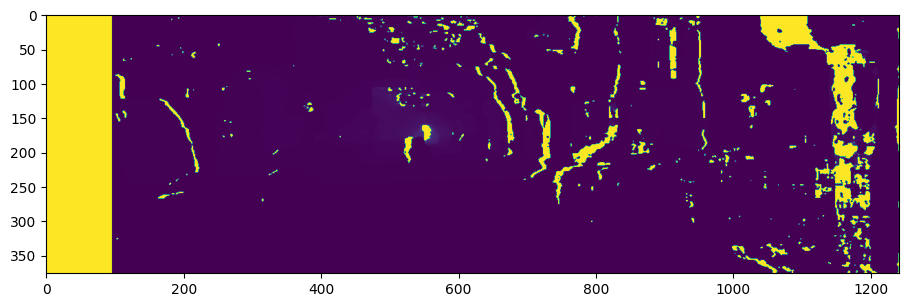

In [88]:
depth, mask = calc_depth_map(D1,Dis2,D1.initC2k,D1.intitC2t,D1.intitC3t)
plt.figure(figsize=(11,7))
plt.imshow(depth);
print(f"The amount of useble depth: {round(100-len(np.where(depth>3000)[0])/(D1.imheight*D1.imwidth)*100,2)}%")
depth[:5,:5]

Number of matches before filtering: 3865
Number of matches after filtering: 812


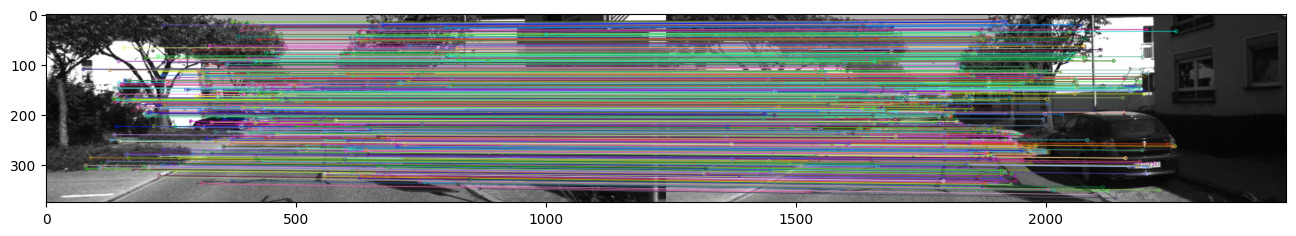

In [12]:
kp1,des1 = extract_features(D1.first_image_left,detector='sift',mask=None)
kp2,des2 = extract_features(D1.second_image_left,detector='sift',mask=None)
matches = match_features(des1, des2, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.45)
print('Number of matches after filtering:', len(matches))
visualize_matches(D1.first_image_left, kp1, D1.second_image_left, kp2, matches)

In [13]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    Tmat = np.eye(4)
    # Place resulting rotation matrix  and translation vector in their proper locations
    # in homogeneous T matrix
    Tmat[:3, :3] = rmat
    Tmat[:3, 3] = tvec.T
    
    return Tmat, image1_points, image2_points

In [14]:
Tmat,image1_points,image2_points = estimate_motion(matches, kp1, kp2, D1.initC2k, depth1=None, max_depth=3000)


In [15]:
Tmat


array([[ 0.99999423,  0.00246673,  0.00233599,  0.02173691],
       [-0.00247145,  0.99999491,  0.00201599,  0.0159124 ],
       [-0.002331  , -0.00202175,  0.99999524, -0.99963709],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Make route visble
make pointcloud with first image featers
Add second pointcloud with pos translation matrix
repeat for rest pic

In [98]:
startfull = datetime.datetime.now()
filter_match_distance=0.45
detector='sift'
matching='FLANN'
stereo_matcher='sgbm' #bm
depth_type = 'stereo'
mask=mask
subset = 10
lidar = False
plot = False

print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                matching))
if filter_match_distance is not None:
    print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
if lidar:
    print('Improving stereo depth estimation with lidar data')
if subset is not None:
    #subset = subset + 1
    num_frames = subset
else:
    # Set num_frames to one less than the number of frames so we have sequential images
    # in the last frame run.
    num_frames = D1.num_frames
    
# if plot:
#     fig = plt.figure(figsize=(14, 14))
#     ax = fig.add_subplot(projection='3d')
#     ax.view_init(elev=-20, azim=270)
#     xs = D1.gt[:, 0, 3]
#     ys = D1.gt[:, 1, 3]
#     zs = D1.gt[:, 2, 3]
#     ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
#     ax.plot(xs, ys, zs, c='k')
    
# Establish homogeneous transformation matrix. First pose is identity    
T_tot = np.eye(4)
trajectory = np.zeros((num_frames, 3, 4))
trajectory[0] = T_tot[:3, :]
imheight = D1.imheight
imwidth = D1.imwidth
# Decompose left camera projection matrix to get intrinsic k matrix
k_left = D1.initC2k #, D1.intitC2r, D1.intitC2t = decompose_projection_matrix(D1.P0)

D1.reset_frames()

for i in range(num_frames - 1):
    # Stop if we've reached the second to last frame, since we need two sequential frames
    #if i == num_frames - 1:
    #    break
    # Start timer for frame
    start = datetime.datetime.now()
    # Get our stereo images for depth estimation
    # low memorie generetor
    D1.next_img()
    image_left = D1.images_left
    image_right = D1.images_right
    # Get next frame in the left camera for visual odometry
    image_plus1 = D1.images_leftPlus

    
    # Estimate depth if using stereo depth estimation (recommended)
    if depth_type == 'stereo':
        depth = Left_Dismap(image_left, 
                                image_right, 
                                matcher=stereo_matcher)
    # Otherwise use Essential Matrix decomposition (ambiguous scale)
    else:
        depth = None
        
    # Supercede stereo depth estimations where lidar points are available
    # if lidar:
    #     if D1.low_memory:
    #         pointcloud = next(D1.pointclouds)
    #     else:
    #         pointcloud = D1.pointclouds[i]
    #     lidar_depth = pointcloud2image(pointcloud, 
    #                                     imheight=imheight, 
    #                                     imwidth=imwidth, 
    #                                     Tr=D1.Tr, 
    #                                     P0=D1.P0)
    #     indices = np.where(lidar_depth < 3000)
    #     depth[indices] = lidar_depth[indices]
        
    # Get keypoints and descriptors for left camera image of two sequential frames
    kp0, des0 = extract_features(image_left, detector, mask)
    kp1, des1 = extract_features(image_plus1, detector, mask)
    
    # Get matches between features detected in the two images
    matches_unfilt = match_features(des0, 
                                    des1, 
                                    matching=matching, 
                                    detector=detector, 
                                    sort=True)
    
    # Filter matches if a distance threshold is provided by user
    if filter_match_distance is not None:
        matches = filter_matches_distance(matches_unfilt, filter_match_distance)
    else:
        matches = matches_unfilt
        
    # Estimate motion between sequential images of the left camera
    Tmat, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
    
    T_tot = T_tot.dot(np.linalg.inv(Tmat))
        
    # Place pose estimate in i+1 to correspond to the second image, which we estimated for
    trajectory[i+1, :, :] = T_tot[:3, :]
    # End the timer for the frame and report frame rate to user
    end = datetime.datetime.now()
    #print('Time to compute frame {}:'.format(i+1), end-start)
    
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = trajectory[:i+2, 0, 3]
        ys = trajectory[:i+2, 1, 3]
        zs = trajectory[:i+2, 2, 3]
        plt.plot(xs, ys, zs, c='chartreuse')
        plt.pause(1e-32)
endfull = datetime.datetime.now()
print(f'Time to run {num_frames} frames: {endfull-startfull}'), 
if plot:        
    plt.close()
depth[:5,:5]

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with FLANN
Filtering feature matches at threshold of 0.45*distance
Time to run 10 frames: 0:00:09.588508


array([[-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.]], dtype=float32)

In [22]:
%matplotlib notebook

In [26]:
%matplotlib inline

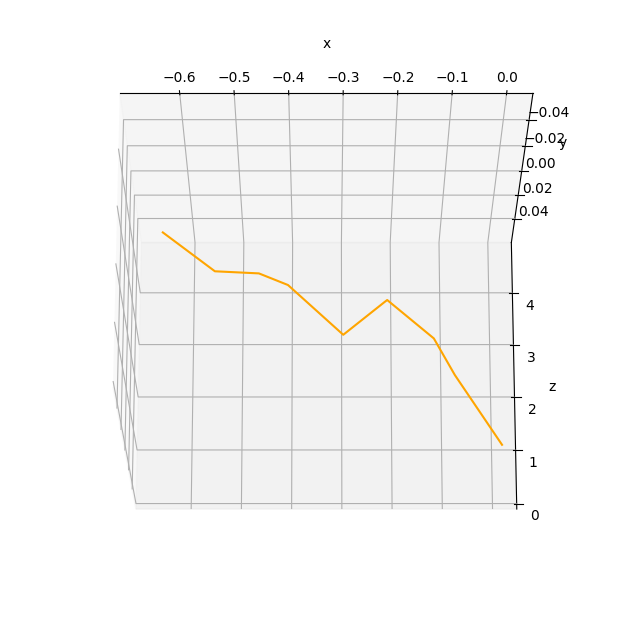

In [90]:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 1], 
        trajectory[:, :, 3][:, 2], label='estimated', color='orange')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

Number of matches before filtering: 3354
Number of matches after filtering: 783
The amount of useble depth: 87.24%


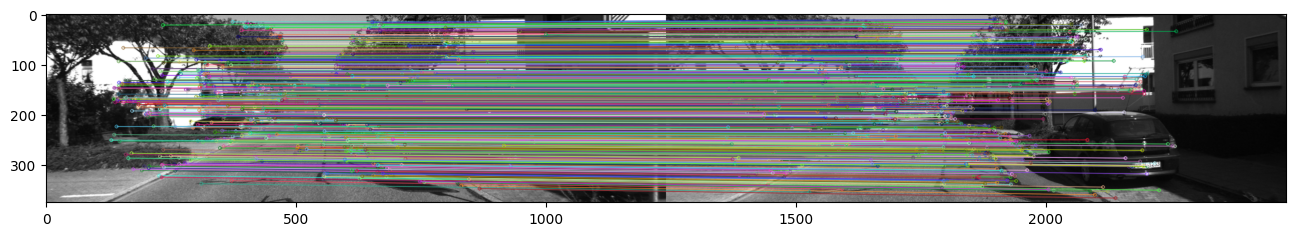

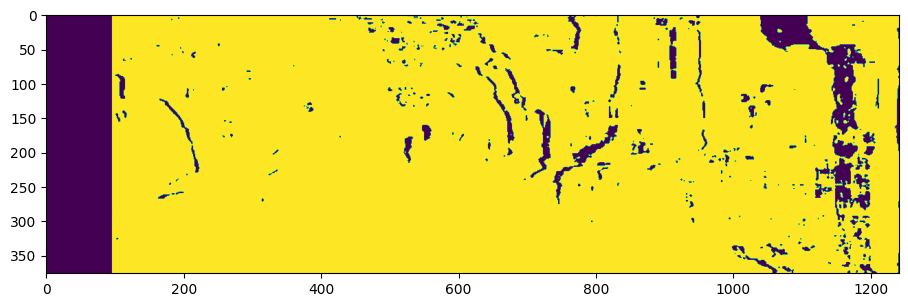

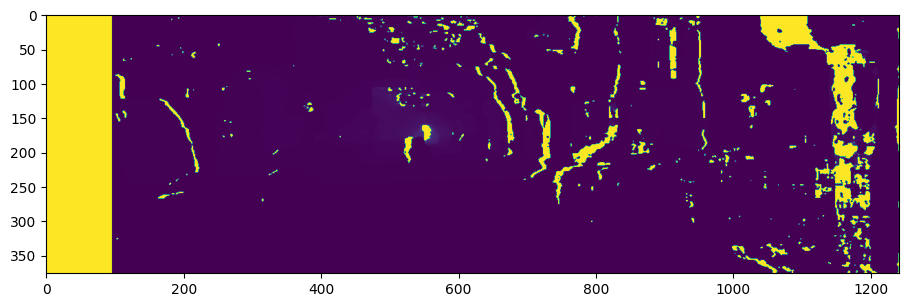

In [182]:
Dis = Left_Dismap(D1.first_image_left, D1.first_image_right, matcher=stereo_matcher)
depth, mask = calc_depth_map(D1,Dis,D1.initC2k,D1.intitC2t,D1.intitC3t)
mask[np.where(depth > 3000)] = 0

kp1,des1 = extract_features(D1.first_image_left,detector='sift',mask=mask)
kp2,des2 = extract_features(D1.second_image_left,detector='sift',mask=mask)
matches = match_features(des1, des2, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.45)
print('Number of matches after filtering:', len(matches))
visualize_matches(D1.first_image_left, kp1, D1.second_image_left, kp2, matches)



plt.figure(figsize=(11,7))
plt.imshow(mask);
plt.figure(figsize=(11,7))
plt.imshow(depth);
print(f"The amount of useble depth: {round(100-len(np.where(depth>3000)[0])/(D1.imheight*D1.imwidth)*100,2)}%")


In [306]:
tm = 9
fx = D1.initC2k[0,0]
fy = D1.initC2k[1,1]
cx = D1.initC2k[0,2]
cy = D1.initC2k[1,2]
p = np.zeros(6)
for i in range(len(matches)):
    u = round(kp1[matches[i].queryIdx].pt[0]) # u = x in pixel matrix
    v = round(kp1[matches[i].queryIdx].pt[1]) # v = y in pixel matrix
    N = round(kp1[matches[i].queryIdx].size)
    ne = [v - round(kp1[matches[i].queryIdx].size/2),u - round(kp1[matches[i].queryIdx].size/2), v + round(kp1[matches[i].queryIdx].size/2),u + round(kp1[matches[i].queryIdx].size/2)]
    # for ix in range(neighborhood[3] - neighborhood[1]):
    #     pix = neighborhood[1] + ix
    #     for iy in range(neighborhood[2] - neighborhood[0]):
    #         piy = neighborhood[0] + iy
    #         Z = depth[piy,pix]
    #         X = (pix - cx) * Z / fx
    #         Y = (piy - cy) * Z / fy
    #         r = D1.first_image_left[piy,pix]
    #         g = r
    #         b = r
    #         if Z < 3000:
    #             p = np.vstack((p, [X,Y,Z,r,g,b]))
    pix = np.arange(ne[0],ne[2])
    piy = np.arange(ne[1],ne[3])
    Y, X = np.meshgrid(piy, pix, indexing='ij')
    matrix = np.vstack((Y.ravel(),X.ravel())).T

    break
# p = p[1:]
# len(p), p[:10]
print(piy,pix)


[526 527 528 529 530 531] [142 143 144 145 146 147]


In [ ]:
y = np.array([1, 2, 3, 4])
y = np.repeat(y, len(y), axis=0)
y = np.reshape(y, (len(y), 1))
x = np.array([10, 11, 12, 13])
x = np.concatenate([x for _ in range(len(x))])
x = np.reshape(x, (len(x), 1))

matrix = np.hstack((y, x))
print(matrix)

In [332]:
y = np.array([1, 2, 3, 4])
x = np.array([10, 11, 12, 13])
# take u,v and make repeat them in a way that the right matrix is given
Y, X = np.meshgrid(y, x, indexing='ij')

matrix = np.vstack((Y.ravel(),X.ravel())).T
matrix = np.hstack((matrix, 
                    depth[matrix[:,0],matrix[:,1]].reshape(-1,1),
                    D1.first_image_left[matrix[:,0],matrix[:,1]].reshape(-1,1),
                    D1.first_image_left[matrix[:,0],matrix[:,1]].reshape(-1,1),
                    D1.first_image_left[matrix[:,0],matrix[:,1]].reshape(-1,1))).astype(int)
matrix[:,0] = (matrix[:,0] - cy) *  matrix[:,2]/ fy
matrix[:,1] = (matrix[:,1] - cx) *  matrix[:,2]/ fy
print(matrix)


[[ -982 -3184  3833    36    36    36]
 [ -982 -3178  3833    43    43    43]
 [ -982 -3173  3833    50    50    50]
 [ -982 -3168  3833    56    56    56]
 [ -976 -3184  3833    38    38    38]
 [ -976 -3178  3833    40    40    40]
 [ -976 -3173  3833    46    46    46]
 [ -976 -3168  3833    55    55    55]
 [ -971 -3184  3833    47    47    47]
 [ -971 -3178  3833    46    46    46]
 [ -971 -3173  3833    48    48    48]
 [ -971 -3168  3833    55    55    55]
 [ -966 -3184  3833    49    49    49]
 [ -966 -3178  3833    50    50    50]
 [ -966 -3173  3833    49    49    49]
 [ -966 -3168  3833    53    53    53]]


In [ ]:
colors = np.ones((p.shape[0], p.shape[1]), dtype=np.uint8) * 255
vertices = p #np.hstack([p, colors])

ply_header = """ply
            format ascii 1.0
            element vertex %(vert_num)d
            property float x
            property float y
            property float z
            property uchar red
            property uchar green
            property uchar blue
            end_header
            """
with open("pointCloudOdo.ply", "w") as f:
            f.write(ply_header % dict(vert_num=len(vertices)))
            np.savetxt(f, vertices, "%f %f %f %d %d %d")
len(vertices)

43963